In [1]:
import gradio as gr
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from demo.cam import generate_gradcam
from captum.attr import LayerGradCam
from PIL import Image
from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from scipy.ndimage import filters
from torch import nn

c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\transformers\models\auto\image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [2]:
def aggregate_attention(attn):
    '''Extract average attention vector'''
    avged = []
    for layer in attn:
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = torch.concat((
            # We zero the first entry because it's what's called
            # null attention (https://aclanthology.org/W19-4808.pdf)
            torch.tensor([0.]).cuda(),
            # usually there's only one item in attns_per_head but
            # on the first generation, there's a row for each token
            # in the prompt as well, so take [-1]
            attns_per_head[-1][1:],
            # add zero for the final generated token, which never
            # gets any attention
            torch.tensor([0.]).cuda(),
        ))
        avged.append(vec / vec.sum())
    return torch.stack(avged).mean(dim=0)

def heterogenous_stack(vecs):
    '''Pad vectors with zeros then stack'''
    max_length = max(v.shape[0] for v in vecs)
    return torch.stack([
        torch.concat((v, torch.zeros(max_length - v.shape[0]).cuda()))
        for v in vecs
    ])

def decode(tokens, tokenizer):
    '''Turn tokens into text with mapping index'''
    full_text = ''
    chunks = []
    
    for i, token in enumerate(tokens):
        text = tokenizer.decode(token)
        full_text += text
        chunks.append(text)
    return full_text, chunks


In [3]:

model_path = "deepseek-ai/Janus-Pro-1B"
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True,
                                             ignore_mismatched_sizes=True # Adding CLS token, will be handled manually
                                             )

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16
# dtype = torch.bfloat32 if torch.cuda.is_available() else torch.float32

if torch.cuda.is_available():
    vl_gpt = vl_gpt.to(dtype).cuda()
else:
    # vl_gpt = vl_gpt.to(torch.float16)
    torch.set_default_device("mps")
    vl_gpt = vl_gpt.to(dtype)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'mps'

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: add_special_token, num_image_tokens, sft_fo

In [4]:
def multimodal_understanding(image, question, seed, top_p, temperature):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()
    
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

    torch.cuda.empty_cache()

    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    pil_images = [Image.fromarray(image)]
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(cuda_device, dtype=dtype)
    


    
    inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
    tokens = prepare_inputs.input_ids
    img_token_positions = prepare_inputs.images_seq_mask

    # print("tokens:", tokens)
    # print("prepared inputs", prepare_inputs)
    print("img_token_positions_shape:", img_token_positions.shape)
    

    outputs = vl_gpt.language_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=prepare_inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False if temperature == 0 else True,
        use_cache=True,
        temperature=temperature,
        top_p=top_p,
        return_dict_in_generate=True,
        output_attentions=True
    )


    sequences = outputs.sequences.cpu().tolist()
    decoded, tokenized = decode(sequences[0], tokenizer)
    # print("answer generated")

    attentions_raw = outputs.attentions
    # attn_selected = attentions_raw[selected_token_idx]
    # attn_m = heterogenous_stack([
    #         torch.tensor([
    #             1 if i == j else 0
    #             for j, token in enumerate(tokens[0])
    #         ]).to(cuda_device)
    #         for i, token in enumerate(tokens[0])
    #     ] + list(map(aggregate_attention, attentions_raw)))

    

    return outputs, attentions_raw, decoded, tokenized, img_token_positions
    

   

In [41]:
# IMG_PATH = "../images/doge.png"
# question = "Find the Visual Encoding text."

# IMG_PATH = "../images/AreaChart.png"
# question = "What is the coffee price in April 2019?"

IMG_PATH = "../images/PieChart.png"
question = "What is the percentage of Xiaomi"

# IMG_PATH = "../images/pie_chart.png"
# question = "dog"

# IMG_PATH = "../images/cat_dog.png"
# question = "cat"


# question = "Text including coffee"

image = Image.open(IMG_PATH)
image_arr = np.array(image)


outputs, attn_m, decoded, tokenized, img_token_positions = multimodal_understanding(image_arr, question, 100, 0.95, 0)

Select Feature Methodology:  same
img_token_positions_shape: torch.Size([1, 631])


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [42]:
len(attn_m) # number of output tokens

23

In [43]:
selected_token_idx = 0
attn_m_token = attn_m[selected_token_idx]
len(attn_m_token) # 24 transformer blocks

24

In [44]:
decoded

'The percentage of Xiaomi in the global smartphone market share in 2021 is 10%.<｜end▁of▁sentence｜>'

In [45]:
tokenized

['The',
 ' percentage',
 ' of',
 ' Xia',
 'omi',
 ' in',
 ' the',
 ' global',
 ' smartphone',
 ' market',
 ' share',
 ' in',
 ' ',
 '2',
 '0',
 '2',
 '1',
 ' is',
 ' ',
 '1',
 '0',
 '%.',
 '<｜end▁of▁sentence｜>']

In [39]:
tokenized[selected_token_idx]

'The'

In [40]:
block = 0
attn_m_token[block].shape

torch.Size([1, 16, 627, 627])

In [34]:
mask = img_token_positions[0]

tg = attn_m_token[1][:, :, :, :len(mask)]

tg = tg[:, :, :, mask]

Generating Grad-CAM with shape: torch.Size([24, 24])


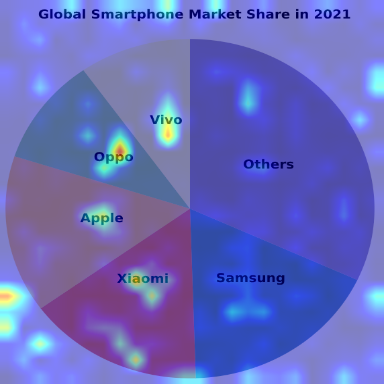

In [35]:
head = 0

# res = tg[0, head, 0].to(torch.float32)
res, _ = tg.max(dim=1)
# res = tg.sum(dim=1)
res = res.to(torch.float32)
grid_size = (int)(res.shape[-1] ** 0.5)
res = res.view(grid_size, grid_size)

generate_gradcam(res, image)